# Monsoon Onset Calculation

Notebook by Fran, 24/5/21

This calculates the onsets in each pixel in Ghana for a certain selection of years. Then it extracts the earliest pixel, latest pixel, and mean onset day for each year. And then it is able to plot that.

Reading in of data from code by Leif

Calculation of monsoon onset from code by Julia

In [7]:
import cmip6
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
#------------------------------------------------------
# Code to calculate the monsoon onset
#   this is defined as having >= day_one_threshold on day t and >= two_day_theshold over day t and t+1 and
#   no dry spells (defined by nconsective_days_dryspell and dry_threshold) starting in the next ndryspell_days
#
# inputs:
#    pr - a numpy array [nt,nlat,nlon] containing daily precipitation in mm/day
#    days - a numpy array [nt] of the day of the year corresponding to pr data
#    day_one_threshold - defaults to 1.0 mm
#    two_day_theshold - defaults to 20.0 mm
#    dry_theshold - defaults to 5.0 mm
#    nconsecutive_days_dryspell - defaults to 7 days
#    ndryspell_days - defaults to 15 days
# 
# returns:
#    onsets - a numpy array [nlat,nlon] with day of the year when onset occured
#------------------------------------------------------------------
# History:
#     created by Julia Crook based on code by Rory Fitzpatrick
#------------------------------------------------------------------
def get_onsets(pr, days, day_one_threshold=1.0,two_day_theshold=20.0, dry_threshold=5.0, nconsecutive_days_dryspell=7, ndryspell_days=15):
    shape=np.shape(pr)
    nt=shape[0]
    nlat=shape[1]
    nlon=shape[2]

    ndays_to_test=ndryspell_days+nconsecutive_days_dryspell   
    onsets=np.zeros((nlat,nlon), int)
    
    for y in range(nlat):
        for x in range(nlon):
            for t in range(nt-ndays_to_test):
                if (pr[t,y,x] >= day_one_threshold and np.sum(pr[t:t+2,y,x]) >= two_day_theshold):
                    # this x and y had heavy enough rain
                    # see if rainfall summed over nconsecutive_days_dryspell days is below dry_threshold
                    # in the next ndryspell_days days
                    low_rain=False
                    for t1 in range(t+2,t+ndryspell_days):
                        if np.sum(pr[t1:t1+nconsecutive_days_dryspell,y,x]) < dry_threshold:
                            low_rain=True
                            break
                    if low_rain == False:
                        # we have found the onset
                        onsets[y,x] = days[t]
                        break
    return onsets

for model in cmip6.Models:
    try:
        fp_model = cmip6.find_cmip6_file(model=model, variable="pr", experiment="ssp119", time_frequency="day", data_root="/badc/cmip6/data/CMIP6/")
        print(f"found data for {model}")
    except:
        print(f"no data found for {model}")

found data for Models.UKESM1_0_LL
no data found for Models.CNRM_CM6_1
found data for Models.MRI_ESM2_0
no data found for Models.GFDL_CM4
no data found for Models.GISS_E2_1_G
no data found for Models.HadGEM3_GC31_LL
no data found for Models.TaiESM1
no data found for Models.AWI_CM_1_1_MR
no data found for Models.BCC_CSM2_MR
no data found for Models.BCC_ESM1
no data found for Models.CAMS_CSM1_0
no data found for Models.FGOALS_f3_L
found data for Models.FGOALS_g3
found data for Models.CanESM5
found data for Models.CNRM_ESM2_1
no data found for Models.ACCESS_ESM1_5
no data found for Models.ACCESS_CM2
no data found for Models.FIO_ESM_2_0
no data found for Models.MPI_ESM_1_2_HAM
no data found for Models.INM_CM4_8
no data found for Models.INM_CM5_0
found data for Models.IPSL_CM6A_LR
found data for Models.MIROC6
no data found for Models.HadGEM3_GC31_MM
no data found for Models.MPI_ESM1_2_HR
no data found for Models.MPI_ESM1_2_LR
no data found for Models.CESM2
no data found for Models.NorCPM1
no

Have chosen here to look at historical models, ssp119 (corresponds to 1.5 warming), ssp245 and ssp585 (scenarios we planned to look at).

Models where there is data for all 4 scenarios:
- UKESM1_0_LL
- MRI_ESM2_0
- FGOALS_g3
- CanESM5
- CNRM_ESM2_1
- IPSL_CM6A_LR
- MIROC6

In [13]:
# use data which was cropped to "Ghana domain" (lon: [-20, 20], lat: [-10, 30]) - ask Leif to process more variables, experiments, etc
data_root = "/gws/pw/j05/cop26_hackathons/leeds/ministry/data/CMIP_Ghana/"
model = cmip6.Models.MIROC6
data_roots = ["/badc/cmip6/data/CMIP6/","/badc/cmip6/data/CMIP6/",data_root,data_root]
expts = ["historical","ssp119","ssp245", "ssp585"]
years_list =[range(1980,2010),range(2040,2070),range(2040,2070),range(2040,2070)]

for i in range(len(expts)):
    expt = expts[i]
    print(expt)
    data_root = data_roots[i]
    years=years_list[i]
    fps = cmip6.find_cmip6_file(model=model, variable="pr", experiment=expt, time_frequency="day", data_root=data_root)
    year=years[0]
    for fp in fps:
        strfp = str(fp)
        file_start_year = int(strfp[-20:-16])
        file_end_year = int(strfp[-11:-7])
        if file_start_year <= year <=file_end_year:
            filepath = fp
            break
    ds = xr.open_dataset(filepath)

    def crop_field(da, bbox_domain):
        lat = bbox_domain["lat"]
        lon = bbox_domain["lon"]

        da_ = da.sel(lat=lat)
        da_ = da_.sel(lon=lon)
        return da_

    bbox_ghana = dict(lat=slice(5, 11), lon=slice(-3.8, 1.5))
    ds_ghana = crop_field(ds,bbox_ghana)
    #unit conversion to mm/day
    ds_ghana.pr.data = ds_ghana.pr.data*86400
    ds_ghana.pr.attrs['units']='mm day-1'
    
    nyears = len(years)
    shp=np.shape(ds_ghana.pr.data)
    shp = (nyears,shp[1],shp[2])
    onsets = np.zeros(shp)
    days = range(0,360)
    earliest_onsets = np.zeros(nyears)
    latest_onsets = np.zeros(nyears)
    mean_onsets = np.zeros(nyears)

    for y in range(nyears):
        year = years[y]
        print(year)
        
        ####checks whether the file is already open
        #yes i know this code is completely absurd i'm sorry
        old_filepath =filepath
        #finds what filepath should be for this year
        for fp in fps:
            strfp = str(fp)
            file_start_year = int(strfp[-20:-16])
            file_end_year = int(strfp[-11:-7])
            if file_start_year <= year <=file_end_year:
                filepath = fp
                break
                
        #if filepath has changed from what it was last time,
        # open the new file
        if filepath != old_filepath:
            ds = xr.open_dataset(filepath)
            ds_ghana = crop_field(ds,bbox_ghana)
            #unit conversion to mm/day
            ds_ghana.pr.data = ds_ghana.pr.data*86400
            ds_ghana.pr.attrs['units']='mm day-1'

        start_idx = int((year-file_start_year)*360) + days[0]
        end_idx = start_idx+len(days)
        year_pr = ds_ghana.pr.data[start_idx:end_idx]

        onsets[y]=get_onsets(year_pr, days,day_one_threshold=2.0,two_day_theshold=20.0, nconsecutive_days_dryspell=7,dry_threshold=5.0)
    onsets_mask =np.ma.masked_less(onsets, 30.)

    for y in range(nyears):
        earliest_onsets[y]=np.min(onsets_mask[y])
        latest_onsets[y]=np.max(onsets_mask[y])
        mean_onsets[y]=np.ma.mean(onsets_mask[y])
    filename = str(model)[7:] + '_' + str(years[0]) + '-' + str(years[-1]+1) + '_' + expt + '_'
    np.save(filename+'early.npy',earliest_onsets)
    np.save(filename+'late.npy',latest_onsets)
    np.save(filename+'mean.npy',mean_onsets)

historical
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
ssp119
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
ssp245
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
ssp585
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


In [ ]:
expts = ["historical","ssp119","ssp245", "ssp585"]
years_list =[range(1980,2010),range(2040,2070),range(2040,2070),range(2040,2070)]

for i in range(1):
    expt = expts[i]
    print(expt)
    years=years_list[i]
    
    filename = str(model)[7:] + '_' + str(years[0]) + '-' + str(years[-1]+1) + '_' + expt + '_'
    earliest_onsets= np.load(filename+'early_5.npy')
    latest_onsets= np.load(filename+'late_95.npy')
    
    plt.figure()
    plt.plot(years,earliest_onsets,label = 'earliest onset')
    plt.plot(years,latest_onsets,label = 'latest onset')
    plt.title(str(model)[7:] + ' monsoon onset day, ' + str(years[0]) + '-' + str(years[-1]+1) + ' ' + expt)
    plt.legend()
    plt.ylim(0,360)
    plt.grid()
    plt.plot([1980,2010],[30,30])

historical
ssp119
ssp245
ssp585


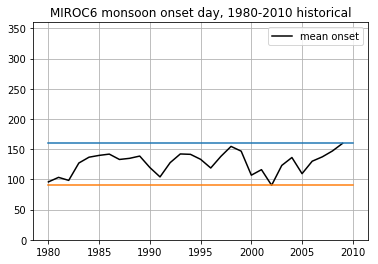

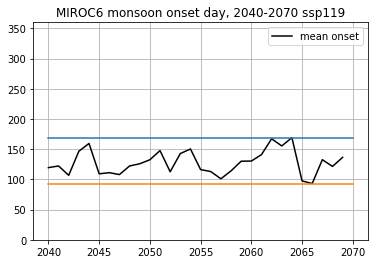

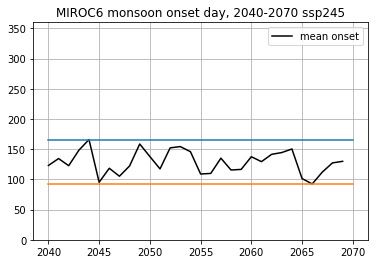

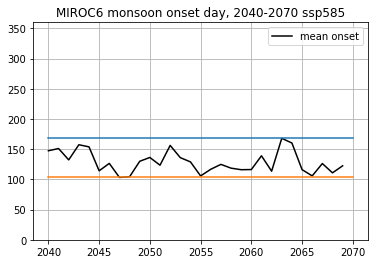

In [14]:
expts = ["historical","ssp119","ssp245", "ssp585"]
years_list =[range(1980,2010),range(2040,2070),range(2040,2070),range(2040,2070)]

for i in range(4):
    expt = expts[i]
    print(expt)
    years=years_list[i]
    
    filename = str(model)[7:] + '_' + str(years[0]) + '-' + str(years[-1]+1) + '_' + expt + '_'
#     earliest_onsets= np.load(filename+'early.npy')
#     latest_onsets= np.load(filename+'late.npy')
    mean_onsets = np.load(filename+'mean.npy')
    plt.figure()
#     plt.plot(years,earliest_onsets,label = 'earliest onset')
#     plt.plot(years,latest_onsets,label = 'latest onset')
    plt.plot(years,mean_onsets,'k',label = 'mean onset')

    plt.title(str(model)[7:] + ' monsoon onset day, ' + str(years[0]) + '-' + str(years[-1]+1) + ' ' + expt)
    plt.legend()
    plt.ylim(0,360)
    plt.grid()
    plt.plot([years[0],years[-1]+1],[max(mean_onsets),max(mean_onsets)])
    plt.plot([years[0],years[-1]+1],[min(mean_onsets),min(mean_onsets)])    

array([101.,  79., 112., 104., 120.,  85.,  85.,  87.,  61.,  57.,  58.,
        95.,  81.,  68.,  83.,  76.,  93.,  76., 110.,  82., 113.,  89.,
        92., 122.,  75., 118.,  47.,  82.,  30., 123.])